### Terse Summary of Problem
why does the model fail to score well on the *same* validation data loaded in the *same* way?


In [1]:
from fastai2.vision.all import *

def piece_class_parse(fn): 
    fn = fn.split('_')[1]
    fn = fn.split('.')[0]
    return fn

path = Path('../../../rf-chess-data/cropped_v1/')

In [2]:
pieces = ImageDataLoaders.from_name_func(
                path, 
                get_image_files(path),
                valid_pct=0.2, 
                seed=42,
                label_func=piece_class_parse, 
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

In [3]:
learn = cnn_learner(pieces, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.551815,0.176599,0.040070,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.316610,0.123759,0.020906,00:04
1,0.235477,0.113388,0.013937,00:04
2,0.183790,0.111233,0.015679,00:04
3,0.143179,0.099981,0.012195,00:04


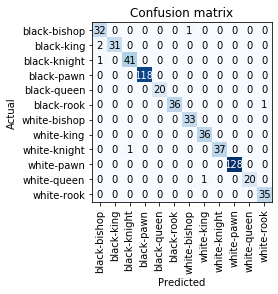

In [4]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Good: arg `dl` allows scoring on another dataset, not connected to `learn`
In this case we use the same dataset, `pieces`, specifically the validation set via `pieces.valid`. But this shows `ClassificationInterpretation` works the way we want it to.

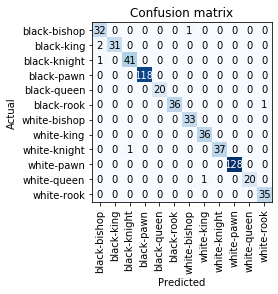

In [5]:
interp2 = ClassificationInterpretation.from_learner(
                                learn=learn, 
                                dl=pieces.valid) 

interp2.plot_confusion_matrix()

##### Load the same dataset, in the exact same way, to a different variable, `pieces2`

In [6]:
pieces2 = ImageDataLoaders.from_name_func(
                path, 
                get_image_files(path),
                valid_pct=0.2, 
                seed=42,
                label_func=piece_class_parse, 
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

### Bad: now the model is not very predictive
when we score on `pieces2.valid`

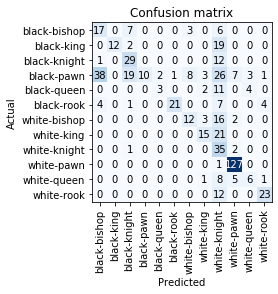

In [7]:
interp3 = ClassificationInterpretation.from_learner(
                                learn=learn, 
                                dl=pieces2.valid) 

interp3.plot_confusion_matrix()

### Final Sanity Checks

In [27]:
pieces2.valid.items == pieces.valid.items

True

### Fix it - use `test_dl` method

In [10]:
same_items = get_image_files(path)
pieces3 = learn.dls.test_dl(same_items, bs=64, with_labels=True)

In [11]:
pieces3

In [16]:
interp4 = ClassificationInterpretation.from_learner(learn,
                                                   dl=pieces3)

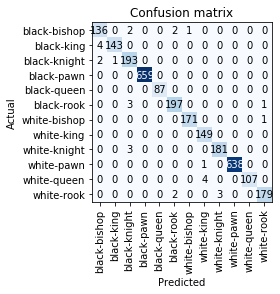

In [17]:
interp4.plot_confusion_matrix()